<a href="https://colab.research.google.com/github/julurisaichandu/nlp/blob/main/glove_vectors_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook 4: How to make a racist model (without trying)
===============

CS 6120 Natural Language Processing, Amir




Saichandu Juluri

In [ ]:
!zip -r dataset.zip /content/data

updating: content/data/ (stored 0%)
  adding: content/data/negative-words.txt (deflated 68%)
  adding: content/data/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/glove.6B.50d.txt (deflated 60%)
  adding: content/data/positive-words.txt (deflated 67%)


Saving notebooks as pdfs
----------

Feel free to add cells to this notebook as you wish. Make sure to leave **code that you've written** and any **answers to questions** that you've written in your notebook. Turn in your notebook as a pdf at the end of lecture's day.


To convert your notebook to a pdf for turn in, you'll do the following:
1. Kernel -> Restart & Run All (clear your kernel's memory and run all cells)
2. File -> Download As -> .html -> open in a browser -> print to pdf

(The download as pdf option doesn't preserve formatting and output as nicely as taking the step "through" html, but will do if the above doesn't work for you.)

*This notebook is part of the [ConceptNet blog](http://blog.conceptnet.io), written by Robyn Speer from [Luminoso](http://luminoso.com).*

## Let's make a sentiment classifier!

Sentiment analysis is a very frequently-implemented task in NLP, and it's no surprise. Recognizing whether people are expressing positive or negative opinions about things has obvious business applications. It's used in social media monitoring, customer feedback, and even automatic stock trading (leading to bots that [buy Berkshire Hathaway when Anne Hathaway gets a good movie review](https://www.theatlantic.com/technology/archive/2011/03/does-anne-hathaway-news-drive-berkshire-hathaways-stock/72661/)).

It's simplistic, sometimes too simplistic, but it's one of the easiest ways to get measurable results from NLP. In a few steps, you can put text in one end and get positive and negative scores out the other, and you never have to figure out what you should do with a parse tree or a graph of entities or any difficult representation like that.

So that's what we're going to do here, following the path of least resistance at every step, obtaining a classifier that should look very familiar to anyone involved in current NLP. For example, you can find this model described in the [Deep Averaging Networks](http://cs.umd.edu/~miyyer/pubs/2015_acl_dan.pdf) paper (Iyyer et al., 2015). This model is not the point of that paper, so don't take this as an attack on their results; it was there as an example of a well-known way to use word vectors.

Here's the outline of what we're going to do:

* Acquire some typical **word embeddings** to represent the meanings of words
* Acquire **training and test data**, with gold-standard examples of positive and negative words
* **Train a classifier**, using gradient descent, to recognize other positive and negative words based on their word embeddings
* Compute **sentiment scores** for sentences of text using this classifier
* **Behold the monstrosity** that we have created

And at that point we will have shown "how to make a racist AI without really trying". Of course that would be a terrible place to leave it, so afterward, we're going to:

* **Measure the problem** statistically, so we can recognize if we're solving it
* **Improve the data** to obtain a semantic model that's more accurate _and_ less racist

## Software dependencies

This tutorial is written in Python, and relies on a typical Python machine-learning stack: `numpy` and `scipy` for numerical computing, `pandas` for managing our data, and `scikit-learn` for machine learning. Later on we'll graph some things with `matplotlib` and `seaborn`.

You could also replace `scikit-learn` with TensorFlow or Keras or something like that, as they can also train classifiers using gradient descent. But there's no need for the deep-learning abstractions they provide, as it only takes a single layer of machine learning to solve this problem.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

## Step 1: Word embeddings

Word embeddings are frequently used to represent words as inputs to machine learning. The words become vectors in a multi-dimensional space, where nearby vectors represent similar meanings. With word embeddings, you can compare words by (roughly) what they mean, not just exact string matches.

Successfully training word vectors requires starting from hundreds of gigabytes of input text. Fortunately, various machine-learning groups have already done this and provided pre-trained word embeddings that we can download.

Two very well-known datasets of pre-trained English word embeddings are **word2vec**, pretrained on Google News data, and **GloVe**, pretrained on the Common Crawl of web pages. We would get similar results for either one, but here we'll use GloVe because its source of data is more transparent.

> **Why does it matter that the word embeddings are "well-known"?**
>
> I'm glad you asked, hypothetical questioner! We're trying to do something extremely typical at each step, and for some reason, comparison-shopping for better word embeddings isn't typical yet. Read on, and I hope you'll come out of this tutorial with the desire to use [modern, high-quality word embeddings](https://github.com/commonsense/conceptnet-numberbatch), especially those that are aware of algorithmic bias and try to mitigate it. But that's getting ahead of things.


### TODO: Download GloVe Embeddings

GloVe comes in three sizes: 6B, 42B, and 840B. The 840B size is powerful, but requires significant post-processing to use it in a way that's an improvement over 42B. The 42B version is pretty good and is also neatly trimmed to a vocabulary of 1 million words. We will be using the 6B version for the sake of boosting speed. But if you are interested in using more powerful embeddings, feel free to download the 42B version instead.


Create a `data` folder under the same directory as this notebook's. Download glove.6B.zip from https://nlp.stanford.edu/data/glove.6B.zip, extract it and move the file `glove.6B.50d.txt` to the `data` folder. Next we define a function to read the simple format of its word vectors.

In [ ]:
# !wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip glove.6B.zip

Archive:  glove.6B.zip
error [glove.6B.zip]:  missing 512753664 bytes in zipfile
  (attempting to process anyway)
error: invalid zip file with overlapped components (possible zip bomb)


In [ ]:
!mkdir data
!mv glove.6B.50d.txt data/

mkdir: cannot create directory ‘data’: File exists
mv: cannot stat 'glove.6B.50d.txt': No such file or directory


In [ ]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)

    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('data/glove.6B.50d.txt')
embeddings.shape

(400001, 50)

## Step 2: A gold-standard sentiment lexicon

We need some input about which words are positive and which words are negative. There are many sentiment lexicons you could use, but we're going to go with a very straightforward lexicon (Hu and Liu, 2004), the same one used by the Deep Averaging Networks paper.


### TODO: Download Sentiment Lexicon

Download the lexicon from http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar and extract it into `data/positive-words.txt` and `data/negative-words.txt`.

Next we define how to read these files, and read them in as the `pos_words` and `neg_words` variables:

In [ ]:
!wget http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar

--2024-09-30 19:44:29--  http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
Resolving www.cs.uic.edu (www.cs.uic.edu)... 131.193.32.29
Connecting to www.cs.uic.edu (www.cs.uic.edu)|131.193.32.29|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar [following]
--2024-09-30 19:44:30--  https://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
Connecting to www.cs.uic.edu (www.cs.uic.edu)|131.193.32.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24020 (23K)
Saving to: ‘opinion-lexicon-English.rar’

opinion-lexicon-Eng 100%[===================>]  23.46K   130KB/s    in 0.2s    

2024-09-30 19:44:30 (130 KB/s) - ‘opinion-lexicon-English.rar’ saved [24020/24020]



In [ ]:
!pip install unrar

In [ ]:
!unrar x opinion-lexicon-English.rar data/

In [ ]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.

    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

## Step 3: Train a model to predict word sentiments

Our data points here are the embeddings of these positive and negative words. We use the Pandas `.loc[]` operation to look up the embeddings of all the words.

Some of these words are not in the GloVe vocabulary, particularly the misspellings such as "fancinating". Those words end up with rows full of `NaN` to indicate their missing embeddings, so we use `.dropna()` to remove them.

In [ ]:
pos_vectors = embeddings.loc[embeddings.index.isin(pos_words)].dropna()
neg_vectors = embeddings.loc[embeddings.index.isin(neg_words)].dropna()

Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are 1 for positive words and -1 for negative words. We also make sure to keep track of the words they're labeled with, so we can interpret the results.

In [ ]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

> **Hold on. Some words are neither positive nor negative, they're neutral. Shouldn't there be a third class for neutral words?**
>
> I think that having examples of neutral words would be quite beneficial, especially because the problems we're going to see come from assigning sentiment to words that shouldn't have sentiment. If we could reliably identify when words should be neutral, it would be worth the slight extra complexity of a 3-class classifier. It requires finding a source of examples of neutral words, because Liu's data only lists positive and negative words.
>
> So I tried a version of this notebook where I put in 800 examples of neutral words, and put a strong weight on predicting words to be neutral. But the end results were not much different from what you're about to see.
>
> **How is this list drawing the line between positive and negative anyway? Doesn't that depend on context?**
>
> Good question. Domain-general sentiment analysis isn't as straightforward as it sounds. The decision boundary we're trying to find is fairly arbitrary in places. In this list, "audacious" is marked as "bad" while "ambitious" is "good". "Comical" is bad, "humorous" is good. "Refund" is good, even though it's typically in bad situations that you have to request one or pay one.
>
> I think everyone knows that sentiment requires context, but when implementing an easy approach to sentiment analysis, you just have to kind of hope that you can ignore context and the sentiments will average out to the right trend.

Using the scikit-learn `train_test_split` function, we simultaneously separate the input vectors, output values, and labels into training and test data, with 10% of the data used for testing.

In [ ]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

Now we make our classifier, and train it by running the training vectors through it for 100 iterations. We use a logistic function as the loss, so that the resulting classifier can output the probability that a word is positive or negative.

In [ ]:
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)

### TODO: Train a SGD Classifier

In [ ]:
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)

SGDClassifier(loss='log_loss', max_iter=100, random_state=0)

We evaluate the classifier on the test vectors. It predicts the correct sentiment for sentiment words outside of its training data 89% of the time. Not bad.

In [ ]:
accuracy_score(model.predict(test_vectors), test_targets)

0.8942307692307693

In [ ]:
model = SGDClassifier(loss='squared_error', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='squared_error', max_iter=100, random_state=0)

In [ ]:
accuracy_score(model.predict(test_vectors), test_targets)

0.875

### TODO: Compute Sentiments

Let's define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data.

In [ ]:
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)

SGDClassifier(loss='log_loss', max_iter=100, random_state=0)

In [ ]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment and return it.
    print(predictions[0])
    print(predictions[1])

    # TODO: Write your code here
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[embeddings.index.isin(words)].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

[-3.8643893  -0.02119884]
[-1.68977889e-04 -8.68582717e+00]


,sentiment
well,3.843190
killed,-8.685658
great,5.661081
free,3.185349
better,5.268084
fell,-0.493469
victory,4.352416
helped,2.650431
intelligence,-0.446912
concerns,-2.409386


More than the accuracy number, this convinces us that the classifier is working. We can see that the classifier has learned to generalize sentiment to words outside of its training data.

## Step 4: Get a sentiment score for text

There are many ways to combine sentiments for word vectors into an overall sentiment score. Again, because we're following the path of least resistance, we're just going to average them.

### TODO: Compute a Text Sentiment Score

In [ ]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]

    # Compute sentiments for all the tokens and return the mean value

    # TODO: Write your code here
    print(vecs_to_sentiment(embeddings.loc[tokens]))
    return vecs_to_sentiment(embeddings.loc[tokens]).mean()


There are many things we could have done better:

- Weight words by their inverse frequency, so that words like "the" and "I" don't cause big changes in sentiment
- Adjust the averaging so that short sentences don't end up with the most extreme sentiment values
- Take phrases into account
- Use a more robust word-segmentation algorithm that isn't confused by apostrophes
- Account for negations such as "not happy"

But all of those would require extra code and wouldn't fundamentally change the results we're about to see. At least now we can roughly compare the relative positivity of different sentences:

In [ ]:
text_to_sentiment("this example is pretty cool")

[-1.89791971 -0.16237787]
[-2.23087092 -0.11365574]
[1.73554184 2.11721518 2.00086882 0.46933224 0.53128114]
[-1.89791971 -0.16237787]
[-2.23087092 -0.11365574]


1.3708478428409872

In [ ]:
text_to_sentiment("this example is okay")

[-1.89791971 -0.16237787]
[-2.23087092 -0.11365574]
[1.73554184 2.11721518 2.00086882 0.14823695]
[-1.89791971 -0.16237787]
[-2.23087092 -0.11365574]


1.5004656977937996

In [ ]:
text_to_sentiment("meh, this example sucks")

[-0.10176308 -2.33555799]
[-1.89791971 -0.16237787]
[-2.23379491  1.73554184  2.11721518 -2.3381599 ]
[-0.10176308 -2.33555799]
[-1.89791971 -0.16237787]


-0.17979944571988005

## Step 5: Behold the monstrosity that we have created

Not every sentence is going to contain obvious sentiment words. Let's see what it does with a few variations on a neutral sentence:

In [ ]:
text_to_sentiment("Let's go get Italian food")

[-0.85012816 -0.5574983 ]
[-0.84389746 -0.5621737 ]
[0.29262986 0.28172376 1.33190706 1.47649648 1.93636396 1.78200152]
[-0.85012816 -0.5574983 ]
[-0.84389746 -0.5621737 ]


1.1835204380240416

In [ ]:
text_to_sentiment("Let's go get Chinese food")

[-0.85012816 -0.5574983 ]
[-0.84389746 -0.5621737 ]
[0.29262986 0.28172376 1.33190706 1.47649648 3.70432927 1.78200152]
[-0.85012816 -0.5574983 ]
[-0.84389746 -0.5621737 ]


1.4781813241527841

In [ ]:
text_to_sentiment("Let's go get Mexican food")

[-0.85012816 -0.5574983 ]
[-0.84389746 -0.5621737 ]
[ 0.29262986  0.28172376  1.33190706  1.47649648 -1.78758369  1.78200152]
[-0.85012816 -0.5574983 ]
[-0.84389746 -0.5621737 ]


0.5628624973184243

This is analogous to what I saw when I experimented with analyzing restaurant reviews using word embeddings, and found out that [all the Mexican restaurants were ending up with lower sentiment](https://blog.conceptnet.io/2017/04/24/conceptnet-numberbatch-17-04-better-less-stereotyped-word-vectors/) for no good reason.

Word vectors are capable of representing subtle distinctions of meaning just by reading words in context. So they're also capable of representing less-subtle things like the biases of our society.

Here are some other neutral statements:

In [ ]:
text_to_sentiment("My name is Emily")

[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]
[2.11956885 0.3149946  2.00086882 0.03311755]
[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]


1.1171374537037189

In [ ]:
text_to_sentiment("My name is Heather")

[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]
[ 2.11956885  0.3149946   2.00086882 -1.2321882 ]
[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]


0.8008110143230732

In [ ]:
text_to_sentiment("My name is Yvette")

[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]
[ 2.11956885  0.3149946   2.00086882 -0.96031902]
[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]


0.8687783099697407

In [ ]:
text_to_sentiment("My name is Shaniqua")

[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]
[ 2.11956885  0.3149946   2.00086882 -1.77731774]
[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]


0.6645286299274739

### TODO: Experiment with your name and your teammates' names

In [ ]:
# TODO: Fill in your name
text_to_sentiment("My name is Steve Paul Jobs")

[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]
[2.11956885 0.3149946  2.00086882 1.90759899 3.11139037 1.79505327]
[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]


1.8749124822503707

In [ ]:
# TODO: Fill in one of your teammates' name
text_to_sentiment("My name is Narayan")

[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]
[ 2.11956885  0.3149946   2.00086882 -0.99775825]
[-2.23297199 -0.11340314]
[-0.86299624 -0.54800164]


0.8594185031936941

Well, dang.

The system has associated wildly different sentiments with people's names. You can look at these examples and many others and see that the sentiment is generally more positive for stereotypically-white names, and more negative for stereotypically-black names.

This is the test that Caliskan, Bryson, and Narayanan used to conclude that [semantics derived automatically from language corpora contain human-like biases](http://opus.bath.ac.uk/55288/), a paper published in *Science* in April 2017, and we'll be using more of it shortly.

## Step 6: Measure the problem

We want to learn how to not make something like this again. So let's put more data through it, and statistically measure how bad its bias is.

Here we have four lists of names that tend to reflect different ethnic backgrounds, mostly from a United States perspective. The first two are lists of predominantly "white" and "black" names adapted from Caliskan et al.'s article. I also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu; these are two more distinct groupings of given names that tend to represent your background.

This data is currently used as a bias-check in the ConceptNet build process, and can be found in the `conceptnet5.vectors.evaluation.bias` module. I'm interested in expanding this to more ethnic backgrounds, which may require looking at surnames and not just given names.

Here are the lists:

In [ ]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],

    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

Now we'll use Pandas to make a table of these names, their predominant ethnic background, and the sentiment score we get for them:

In [ ]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

[-0.76892129 -0.62271257]
[-0.12672713 -2.12841356]
[-1.06046083 -0.42510092]
[-0.05828261 -2.87145135]
[-0.97774372 -0.47185953]
[-2.26850883 -0.10921945]
[-3.15496623 -0.04357562]
[-2.55926062 -0.08051823]


A sample of the data:

In [ ]:
name_sentiments.iloc[::25]

,sentiment,group
ali,0.146209,Arab/Muslim
ayaan,-6.065590,Arab/Muslim
malika,-3.107048,Black
ana,-1.792622,Hispanic
andrew,0.635782,White
sara,2.416037,White


Now we can visualize the distribution of sentiment we get for each kind of name:

(-10.0, 10.0)

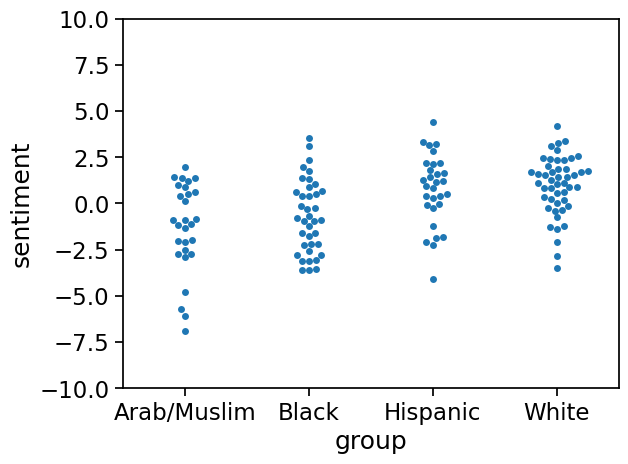

In [ ]:
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

We can see that as a bar-plot, too, showing the 95% confidence intervals of the means.

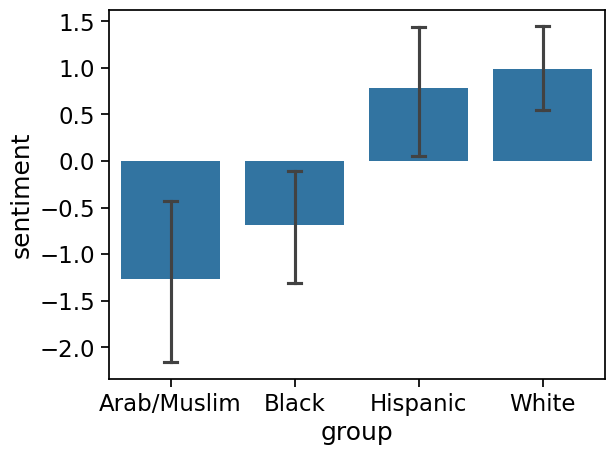

In [ ]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

And finally we can break out the serious statistical machinery, using the [statsmodels](http://www.statsmodels.org/stable/index.html) package, to tell us how big of an effect this is (along with a bunch of other statistics).

In [ ]:
ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
ols_model.summary().tables[0]

Dep. Variable:,sentiment,R-squared:,0.196
Model:,OLS,Adj. R-squared:,0.178
Method:,Least Squares,F-statistic:,11.35
Date:,"Mon, 30 Sep 2024",Prob (F-statistic):,1.04e-06
Time:,20:05:59,Log-Likelihood:,-297.53
No. Observations:,144,AIC:,603.1
Df Residuals:,140,BIC:,614.9
Df Model:,3,,
Covariance Type:,nonrobust,,


The F-statistic is the ratio of the variation between groups to the variation within groups, which we can take as a measure of overall ethnic bias.

The probability, right below that, is the probability that we would see this high of an F-statistic given the null hypothesis: that is, given data where there was no difference between ethnicities. The probability is very, very low. If this were a paper, we'd get to call the result "highly statistically significant".

Out of all these numbers, the F-value is the one we really want to improve. A lower F-value is better.

In [ ]:
ols_model.fvalue

NameError: name 'ols_model' is not defined

### What about another dataset?

You may think this is a problem that only GloVe has. If the system weren't trained on all of the Common Crawl (which contains lots of unsavory sites and like 20 copies of Urban Dictionary), maybe it wouldn't have gone bad. What about good old word2vec, trained on Google News?

Turns out word2vec is even worse. With an F-value over 15, it has even larger differences in sentiment between groups.

In retrospect, expecting _news_ to be safe from algorithmic bias was rather a lot to hope for.

### There is no trade-off

Some people expect that fighting algorithmic racism is going to come with some sort of trade-off. There's no trade-off here. You can have data that's better and less racist. You can have data that's better *because* it's less racist. There was never anything "accurate" about the overt racism that word2vec and GloVe learned.

## Other approaches

This is of course only one way to do sentiment analysis. All the steps we used are common, but you probably object that you wouldn't do it that way. But if you have your own process, I urge you to see if your process is encoding prejudices and biases in the model it learns.

Instead of or in addition to changing your source of word vectors, you could try to fix this problem in the output directly. It may help, for example, to build a stronger model of whether sentiment should be assigned to words at all, designed to specifically exclude names and groups of people.

You could abandon the idea of inferring sentiment for words, and only count the sentiment of words that appear exactly in the list. This is perhaps the most common form of sentiment analysis -- the kind that includes no machine learning at all. Its results will be no more biased than whoever made the list. But the lack of machine learning means that this approach has low recall, and the only way to adapt it to your data set is to edit the list manually.

As a hybrid approach, you could produce a large number of inferred sentiments for words, and have a human annotator patiently look through them, making a list of exceptions whose sentiment should be set to 0. The downside of this is that it's extra work; the upside is that you take the time to actually see what your data is doing. And that's something that I think should happen more often in machine learning anyway.
